# Summary

The main model we are seeking to develop makes multiclass predictions based on chest x-ray (CXR) images to determine whether a given patient has bacterial pneumonia, viral pneumonia, or if the CXR is negative for pneumonia. A secondary model we developed helps to perform intial screening of the CXR to determine whether pneumonia is present in the image at all. In tandem, these models provide a robust ML product for screening and triaging pneumonia patients that is designed to be used in a "human in the loop" protocol as a second set of eyes on chest x-rays of children in low-resource settings. A growing body of literature supports this practice, albeit with models that are more complex and typically provide annotation features. 

The general approach to building our models is an iterative approach that starts with a relatively simple convolutional neural net containing 3 convolution layers and 2 densely connected layers for a total of 5 layers (3 hidden). Since we are designing this model to function with a human in the loop, accuracy was our primary optimization metric with recall as a strong secondary consideration. Sacrificing accuracy for sensitivity in the context of this deployment schema will tend to unnecessarily increase the workload for the end user (the radiologist) while providing less insight. Note that this is only safe to do because a human is still involved.

# CNN Modeling

***Note that much of the code for different models has been pushed out into markdown cells after having been run. This is due to severe memory bloat issues during training that caused errors to arise during training on the AWS EC2 server. This should also allow the notebook to be run from top to bottom in a timely manner. If you wish to run the previous model iterations or examine them with IDE features on, simply convert them back to code cells.***

In [1]:
# General libraries
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
import math

# Deep learning libraries
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import PIL



Data is imported from the directory via the below ImageDataGenerator objects. These objects import the images at execution time and convert them to numpy arrays containing scaled pixel values that can be fed into the convolutional neural networks that we are constructing. They also conveniently perform image augmentation at execution time for training images to prevent overfitting, as well as providing a validation split. 

In [2]:
#Image generators for importing data and providing validation split for training
train_image = ImageDataGenerator(rescale=1/255,
                                 width_shift_range=0.05,
                                 height_shift_range=0.05,
                                 horizontal_flip=True,
                                 shear_range=10,
                                 brightness_range=[0.95,1.05],
                                 validation_split=.2)

#attempting to create validation data set without augmentations applied to the training set
#random seed is set upon generation of the data, thus should prevent data leakage
validation_image = ImageDataGenerator(rescale=1/255,
                                     validation_split=.2)

test_image = ImageDataGenerator(rescale=1/255)

In [3]:
#training data processing
train_gen = train_image.flow_from_directory(
    directory='chest_xray/train', 
    target_size=(128, 128),color_mode='grayscale',
    batch_size=32, 
    class_mode='categorical', subset='training', interpolation="lanczos",
    seed=42)

Found 4186 images belonging to 3 classes.


In [4]:
#validation data processing
val_gen = validation_image.flow_from_directory(
    directory='chest_xray/train', 
    target_size=(128, 128),color_mode='grayscale',
    batch_size=32, 
    class_mode='categorical', subset='validation', interpolation="lanczos",
    seed=42)

Found 1045 images belonging to 3 classes.


In [5]:
#testing data processing
test_gen = test_image.flow_from_directory(
    directory='chest_xray/test', 
    target_size=(128, 128), color_mode='grayscale', 
    batch_size=32, 
    class_mode='categorical', interpolation="lanczos",
    shuffle=False,
    seed=42)

Found 624 images belonging to 3 classes.


### Begin Iterative Modeling

#initial model
model = models.Sequential()
model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=model_checkpoint_callback)

model.summary()

#2nd model iteration - increased kernel size, added padding
kernel = (8, 8)

model2 = models.Sequential()
model2.add(layers.Conv2D(filters=32,
                        kernel_size=kernel,
                        activation='relu',
                        input_shape=(128, 128, 1),
                        padding='valid'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Conv2D(128, kernel, activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, kernel, activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model2.fit(train_gen,epochs=10, validation_data=val_gen, callbacks=model_checkpoint_callback)

model2.summary()

#3rd model iteration - increased pool size
kernel = (8, 8)
pool = (3, 3)

model3 = models.Sequential()
model3.add(layers.Conv2D(filters=32,
                        kernel_size=kernel,
                        activation='relu',
                        input_shape=(128, 128, 1),
                        padding='valid'))
model3.add(layers.MaxPooling2D(pool_size=pool))

#hidden layers
model3.add(layers.Conv2D(128, kernel, activation='relu'))
model3.add(layers.MaxPooling2D(pool))
model3.add(layers.Conv2D(128, kernel, activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(3, activation='softmax'))

model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model3.fit(train_gen,epochs=10,validation_data=val_gen)

model3.summary()

#4th model iteration - changed activation function for hidden layers to tanh, converted last hidden layer to dropout layer
kernel = (8, 8)
pool = (3, 3)

model4 = models.Sequential()
model4.add(layers.Conv2D(filters=32,
                        kernel_size=kernel,
                        activation='relu',
                        input_shape=(128, 128, 1),
                        padding='valid'))
#hidden layers
model4.add(layers.MaxPooling2D(pool_size=pool))
model4.add(layers.Conv2D(128, kernel, activation='tanh'))
model4.add(layers.MaxPooling2D(pool))
model4.add(layers.Conv2D(128, kernel, activation='tanh'))
model4.add(layers.Flatten())
model4.add(layers.Dense(128, activation='tanh'))
model4.add(layers.Dropout(rate=.25))
#output layer
model4.add(layers.Dense(3, activation='softmax'))

model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model4.fit(train_gen,epochs=10,validation_data=val_gen, callbacks=model_checkpoint_callback)

model4.summary()

#5th model iteration - reverted activation function changes, kept dropout layer
kernel = (8, 8)
pool = (3, 3)

model5 = models.Sequential()
model5.add(layers.Conv2D(filters=32,
                        kernel_size=kernel,
                        activation='relu',
                        input_shape=(128, 128, 1),
                        padding='valid'))
#hidden layers
model5.add(layers.MaxPooling2D(pool_size=pool))
model5.add(layers.Conv2D(128, kernel, activation='relu'))
model5.add(layers.MaxPooling2D(pool))
model5.add(layers.Conv2D(128, kernel, activation='relu'))
model5.add(layers.Flatten())
model5.add(layers.Dense(128, activation='relu'))
model5.add(layers.Dropout(rate=.25))
#output layer
model5.add(layers.Dense(3, activation='softmax'))

#compiling and fitting the model
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model5.fit(train_gen,epochs=10,validation_data=val_gen, callbacks=model_checkpoint_callback)

model5.summary()

#5th model iteration - added 1 extra convlution, reduced kernel size
kernel = (8, 8)
pool = (3, 3)

model6 = models.Sequential()
model6.add(layers.Conv2D(filters=32,
                        kernel_size=kernel,
                        activation='relu',
                        input_shape=(128, 128, 1),
                        padding='valid'))
#hidden layers
model6.add(layers.MaxPooling2D(pool_size=pool))
model6.add(layers.Conv2D(128, kernel, activation='relu'))
model6.add(layers.Conv2D(128, kernel, activation='relu'))
model6.add(layers.MaxPooling2D(pool))
model6.add(layers.Conv2D(128, kernel, activation='relu'))
model6.add(layers.Flatten())
model6.add(layers.Dense(128, activation='relu'))
model6.add(layers.Dropout(rate=.25))
#output layer
model6.add(layers.Dense(3, activation='softmax'))

#compiling and fitting the model
model6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model6.fit(train_gen,epochs=20,validation_data=val_gen, callbacks=model_checkpoint_callback)

model6.summary()

# Larger Image Sizes

Due to the granularity typically involved in human interpretation of Chest X-ray images (i.e. identifying presence and patterns of infiltrate in the lungs) we are experimenting with increasing the size of the images to achieve greater precision. This poses a greater risk of overfitting, and increases training time, however, it is possible that using convolutions and pooling, our model may be able to aggregate and interpret this finer detail if tuned appropriately.

#training data processing using half length and width of original image size
train_gen_0 = train_image.flow_from_directory(
    directory='chest_xray/train', 
    target_size=(534, 381),color_mode='grayscale',
    batch_size=64, 
    class_mode='categorical', subset='training', interpolation="lanczos",
    seed=42)

#validation data processing using half length and width of original image size
val_gen_0 = validation_image.flow_from_directory(
    directory='chest_xray/train', 
    target_size=(534, 381),color_mode='grayscale',
    batch_size=128, 
    class_mode='categorical', subset='validation', interpolation="lanczos",
    seed=42)

#initial model using half length and width of original image size
model7 = models.Sequential()

#input layer
model7.add(layers.Conv2D(filters=3,
                        kernel_size=(20, 20),
                        activation='swish',
                        input_shape=(534, 381, 1)))
model7.add(layers.Flatten())

#hidden layers
model7.add(layers.Dense(128, activation='swish'))
model7.add(layers.Dense(64, activation='swish'))
model7.add(layers.Dense(32, activation='swish'))

#output layer
model7.add(layers.Dense(3, activation='softmax'))

#compile and compute
model7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'AUC'])
#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model7.fit(train_gen_0, epochs=20, validation_data=val_gen_0, callbacks=model_checkpoint_callback)

# Deep Models

#Going Deeper
model8 = models.Sequential()

#input layer
model8.add(layers.Conv2D(filters=32,
                        kernel_size=(20, 20),
                        activation='relu',
                        input_shape=(128, 128, 1)))
model8.add(layers.MaxPooling2D(pool_size=(2, 2)))

#hidden layers
model8.add(layers.Conv2D(32, (2, 2), activation='relu'))
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Conv2D(32, (2, 2), activation='relu'))
model8.add(layers.Flatten())
model8.add(layers.Dense(64, activation='relu'))
model8.add(layers.Dense(32, activation='relu'))
model8.add(layers.Dense(16, activation='relu'))
model8.add(layers.Dense(8, activation='relu'))

#output layer
model8.add(layers.Dense(3, activation='softmax'))

#compile and compute
model8.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'AUC'])
#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model8.fit(train_gen, epochs=50, validation_data=val_gen, callbacks=model_checkpoint_callback)

model8.summary()

#Going Even Deeper
model9 = models.Sequential()

#input layer
model9.add(layers.Conv2D(filters=32,
                        kernel_size=(20, 20),
                        activation='relu',
                        input_shape=(128, 128, 1)))
model9.add(layers.MaxPooling2D(pool_size=(2, 2)))

#hidden layers
model9.add(layers.Conv2D(32, (2, 2), activation='relu'))
model9.add(layers.Flatten())
#dense layers for interpretation
model9.add(layers.Dense(64, activation=layers.LeakyReLU()))
model9.add(layers.Dense(64, activation='relu'))
model9.add(layers.Dense(64, activation=layers.LeakyReLU()))
model9.add(layers.Dense(64, activation='relu'))
model9.add(layers.Dropout(.5))
model9.add(layers.Dense(64, activation=layers.LeakyReLU()))
model9.add(layers.Dense(64, activation='relu'))
model9.add(layers.Dropout(.5))
model9.add(layers.Dense(64, activation=layers.LeakyReLU()))
model9.add(layers.Dense(64, activation='relu'))

#output layer
model9.add(layers.Dense(3, activation='softmax'))

#compile and compute
model9.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'AUC'])
#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints/cp.ckpt",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model9.fit(train_gen, epochs=50, validation_data=val_gen, callbacks=model_checkpoint_callback)

# Final Multiclass Model

In [6]:
#Went too deep - trying new activation function in hidden layers
model0 = models.Sequential()

#input layer
model0.add(layers.Conv2D(filters=16,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 1)))
model0.add(layers.MaxPooling2D(pool_size=(3, 3)))

#hidden layers
model0.add(layers.Conv2D(32, (3, 3), activation='swish'))
model0.add(layers.MaxPooling2D((3, 3)))
model0.add(layers.Conv2D(32, (3, 3), activation='swish'))
model0.add(layers.Flatten())
model0.add(layers.Dense(64, activation='swish'))
model0.add(layers.Dense(32, activation='swish'))
model0.add(layers.Dense(16, activation='swish'))
model0.add(layers.Dense(8, activation='swish'))

#output layer
model0.add(layers.Dense(3, activation='softmax'))

#compile and compute
model0.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'AUC'])
#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints/cp.ckpt",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

multi_history = model0.fit(train_gen, epochs=30, validation_data=val_gen, callbacks=model_checkpoint_callback)

Epoch 1/30
131/131 [==============================] - 60s 461ms/step - loss: 0.9021 - accuracy: 0.5815 - auc: 0.7586 - val_loss: 0.9760 - val_accuracy: 0.6067 - val_auc: 0.7586
Epoch 2/30
131/131 [==============================] - 61s 468ms/step - loss: 0.6260 - accuracy: 0.7296 - auc: 0.8887 - val_loss: 0.5880 - val_accuracy: 0.7598 - val_auc: 0.9093
Epoch 3/30
131/131 [==============================] - 65s 495ms/step - loss: 0.5799 - accuracy: 0.7465 - auc: 0.9030 - val_loss: 0.6501 - val_accuracy: 0.7378 - val_auc: 0.8913
Epoch 4/30
131/131 [==============================] - 64s 486ms/step - loss: 0.5526 - accuracy: 0.7637 - auc: 0.9128 - val_loss: 0.7297 - val_accuracy: 0.7120 - val_auc: 0.8692
Epoch 5/30
131/131 [==============================] - 64s 491ms/step - loss: 0.5274 - accuracy: 0.7661 - auc: 0.9193 - val_loss: 0.6127 - val_accuracy: 0.7321 - val_auc: 0.9039
Epoch 6/30
131/131 [==============================] - 63s 484ms/step - loss: 0.5087 - accuracy: 0.7769 - auc: 0.924

# Binary Classification

Link to Binary Classification Repo: https://github.com/StefanoCaruso456/Pediatric_Pneumonia_Binary.git

In [7]:
#see secondary repo - binary classification model adapted from Stefano's work in separate repository
#creating image data generators to convert images to numpy pixel arrays
train_image_binary = ImageDataGenerator(rescale=1/255, zoom_range=0.3, vertical_flip=True, validation_split=0.2)
val_image_binary = ImageDataGenerator(rescale=1/255, zoom_range=0.3, vertical_flip=True, validation_split=0.2)
test_image_binary = ImageDataGenerator(rescale=1/255)

In [8]:
#data generators for binary classifier
train_gen_binary = train_image_binary.flow_from_directory(
    directory='CXR_Binary/train', 
    target_size=(128, 128),color_mode='grayscale',
    batch_size=32, 
    class_mode='categorical', subset='training', interpolation="lanczos",
    shuffle=True,
    seed=42)

val_gen_binary = val_image_binary.flow_from_directory(
    directory='CXR_Binary/train', 
    target_size=(128, 128),color_mode='grayscale',
    batch_size=32, 
    class_mode='categorical', subset='validation',interpolation="lanczos",
    shuffle=True,
    seed=42)

test_gen_binary = test_image_binary.flow_from_directory(
    directory='CXR_Binary/test', 
    target_size=(128, 128),color_mode='grayscale', 
    batch_size=32, 
    class_mode='categorical',interpolation="lanczos",
    shuffle=False,
    seed=42)

Found 4499 images belonging to 2 classes.
Found 1123 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
#Final Binary Model
model_binary = models.Sequential()
model_binary.add(layers.Conv2D(filters=10,
                        kernel_size=(3, 3),
                        activation='swish',
                        input_shape=(128, 128, 1)))
model_binary.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_binary.add(layers.Conv2D(64, (3, 3), activation='swish'))
model_binary.add(layers.MaxPooling2D((2, 2)))
model_binary.add(layers.Conv2D(32, (3, 3), activation='swish'))
model_binary.add(layers.Flatten())
model_binary.add(layers.Dense(16, activation='swish'))
model_binary.add(layers.Dense(2, activation='sigmoid'))

model_binary.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

binary_history = model_binary.fit(train_gen_binary,epochs=30, batch_size=32,validation_data=val_gen_binary)

Epoch 1/30
141/141 [==============================] - 90s 640ms/step - loss: 0.4622 - accuracy: 0.7948 - val_loss: 0.3270 - val_accuracy: 0.8566
Epoch 2/30
141/141 [==============================] - 84s 598ms/step - loss: 0.3715 - accuracy: 0.8477 - val_loss: 0.3131 - val_accuracy: 0.8611
Epoch 3/30
141/141 [==============================] - 86s 607ms/step - loss: 0.3321 - accuracy: 0.8593 - val_loss: 0.2997 - val_accuracy: 0.8620
Epoch 4/30
141/141 [==============================] - 85s 600ms/step - loss: 0.3123 - accuracy: 0.8717 - val_loss: 0.2789 - val_accuracy: 0.8771
Epoch 5/30
141/141 [==============================] - 89s 630ms/step - loss: 0.2679 - accuracy: 0.8871 - val_loss: 0.2220 - val_accuracy: 0.9056
Epoch 6/30
141/141 [==============================] - 85s 600ms/step - loss: 0.2403 - accuracy: 0.9062 - val_loss: 0.1976 - val_accuracy: 0.9216
Epoch 7/30
141/141 [==============================] - 83s 588ms/step - loss: 0.2276 - accuracy: 0.9115 - val_loss: 0.1810 - val_ac

# Evaluation

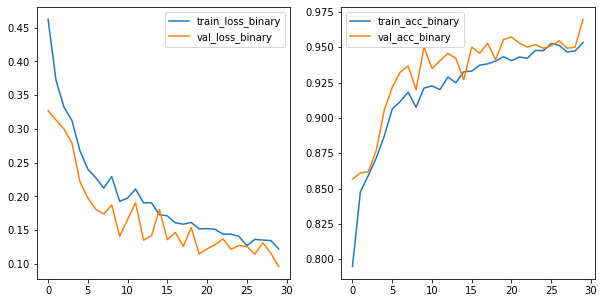

In [10]:
#import library for visuals
import seaborn as sns

#training charts for binary model
train_loss_binary = binary_history.history['loss']
train_acc_binary = binary_history.history['accuracy']
val_loss_binary = binary_history.history['val_loss']
val_acc_binary = binary_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=binary_history.epoch, y=train_loss_binary, ax=ax1, label='train_loss_binary')
sns.lineplot(x=binary_history.epoch, y=train_acc_binary, ax=ax2, label='train_acc_binary')

sns.lineplot(x=binary_history.epoch, y=val_loss_binary, ax=ax1, label='val_loss_binary')
sns.lineplot(x=binary_history.epoch, y=val_acc_binary, ax=ax2, label='val_acc_binary');

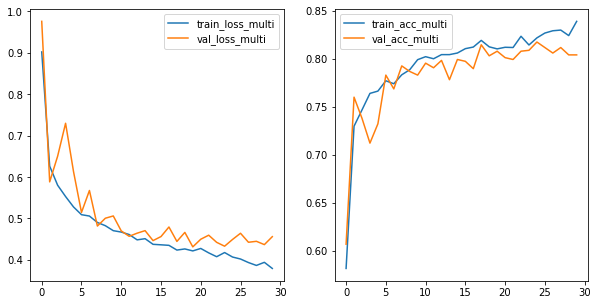

In [11]:
#training charts for multiclass model
train_loss_multi = multi_history.history['loss']
train_acc_multi = multi_history.history['accuracy']
val_loss_multi = multi_history.history['val_loss']
val_acc_multi = multi_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=multi_history.epoch, y=train_loss_multi, ax=ax1, label='train_loss_multi')
sns.lineplot(x=multi_history.epoch, y=train_acc_multi, ax=ax2, label='train_acc_multi')

sns.lineplot(x=multi_history.epoch, y=val_loss_multi, ax=ax1, label='val_loss_multi')
sns.lineplot(x=multi_history.epoch, y=val_acc_multi, ax=ax2, label='val_acc_multi');

In [12]:
#pull out test metrics
test_loss_binary, test_acc_binary = model_binary.evaluate(test_gen_binary)
test_loss_multi, test_acc_multi, test_auc = model0.evaluate(test_gen)

20/20 [==============================] - 8s 402ms/step - loss: 0.5931 - accuracy: 0.8333 - auc: 0.9250


In [13]:
#prediction probabilities
y_binary = model_binary.predict(test_gen_binary)
y_multi = model0.predict(test_gen)

In [14]:
y_multi

array([[8.2432902e-01, 2.1679797e-03, 1.7350303e-01],
       [5.9717196e-01, 7.7833552e-03, 3.9504465e-01],
       [9.0304869e-01, 2.3197846e-03, 9.4631493e-02],
       ...,
       [6.9295841e-01, 9.0833576e-03, 2.9795820e-01],
       [3.2401311e-01, 5.6518393e-04, 6.7542171e-01],
       [1.9526047e-01, 5.0246934e-05, 8.0468929e-01]], dtype=float32)

confusion matrix

In [20]:
#imports
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

In [29]:
#predictions
bin_pred = np.argmax(y_binary, axis=-1)
multi_pred = np.argmax(y_multi, axis=-1)
#labels
bin_true = test_gen_binary.labels
multi_true = test_gen.labels

In [30]:
bin_pred

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

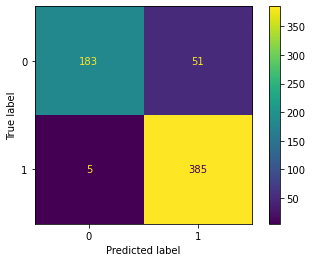

In [33]:
#binary confusion matrix
matrix = confusion_matrix(bin_true, bin_pred)
binary_matrix = ConfusionMatrixDisplay(matrix)
binary_matrix.plot()

In [35]:
recall_score(bin_true, bin_pred)

0.9871794871794872

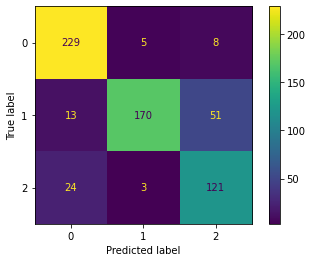

In [34]:
#multi confusion matrix
matrix = confusion_matrix(multi_true, multi_pred)
multi_matrix = ConfusionMatrixDisplay(matrix)
multi_matrix.plot()

Generally, accuracy performance of models noted during evaluation suggests that extending training epochs may yield small further improvements in the model performance. However, additional changes to the network structure would likely yield larger improvements. 

Despite optimizing for accuracy, our models demonstrate an aggressive sensitivity and tend to make more type 1 errors (false positive) than type 2 (false negative). While this is favorable for our use case, it may represent an issue with class imbalance in our data since bacterial pneumonia alone makes up nearly 50% of the provided CXRs. Thus, our model has a tendency to classify images as "pneumonia" and "bacterial pneumonia" more frequently than actually occurs in the data. The downstream implications of this type of error are less harmful than other types, but future development should seek to eliminate these errors.

# Sample Image to demonstrate use of probabilities, etc.

Here we copied an image over to a new directory and ran it through our multiclass model to demonstrate what would be provided to a potential radiologist using our model. The demonstration was included in the non-technical presentation slides found in this repository.

In [15]:
#sample image import
sample_gen = test_image.flow_from_directory(
    directory='chest_xray/sample', 
    target_size=(128, 128), color_mode='grayscale', 
    batch_size=1, 
    class_mode='categorical', interpolation="lanczos",
    seed=42)

Found 1 images belonging to 3 classes.


In [16]:
model0.predict(sample_gen)

array([[8.1123459e-01, 9.3937706e-05, 1.8867151e-01]], dtype=float32)

In [17]:
import matplotlib.image as mpimg

In [18]:
img = mpimg.imread("./chest_xray/sample/BACTERIA/BACTERIA-2034017-0005.jpeg")

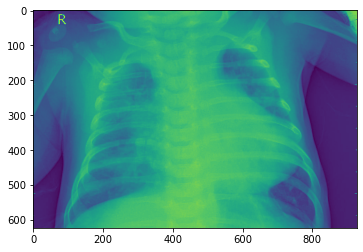

In [19]:
plt.imshow(img)